# PyTorch mutual information neural estimation tests

Trivial tests with multivariate Gaussian and uniform distribution

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import mutinfo
import torchmine

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 2


In [5]:
from tqdm import tqdm

In [6]:
from mutinfo.utils.dependent_norm import multivariate_normal_from_MI
from mutinfo.utils.synthetic import normal_to_uniform

In [7]:
from misc.modules import *
from misc.plots import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-24chidzp because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [8]:
mutual_information = 5.0

n_samples = 6000
X_dimension = 4
Y_dimension = 4

In [9]:
random_variable = multivariate_normal_from_MI(X_dimension, Y_dimension, mutual_information)
X_Y = normal_to_uniform(random_variable.rvs(n_samples))

# Toggle this to run tests with uniformly distributed data instead of Gaussians.
use_uniform_distribution = False
if use_uniform_distribution:
    from scipy.special import ndtr
    X_Y = ndtr(X_Y)

X = X_Y[:, 0:X_dimension]
Y = X_Y[:, X_dimension:X_dimension + Y_dimension]
Z = X[np.random.permutation(X.shape[0])]

In [10]:
batch_size = 500 #n_samples
dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(Z, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = BasicDenseT(X_dimension, Y_dimension).to(device)

In [12]:
# Training parameters.
loss = torchmine.loss.DVRLoss(biased=False, alpha=1e-2)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
import matplotlib
from matplotlib import pyplot as plt

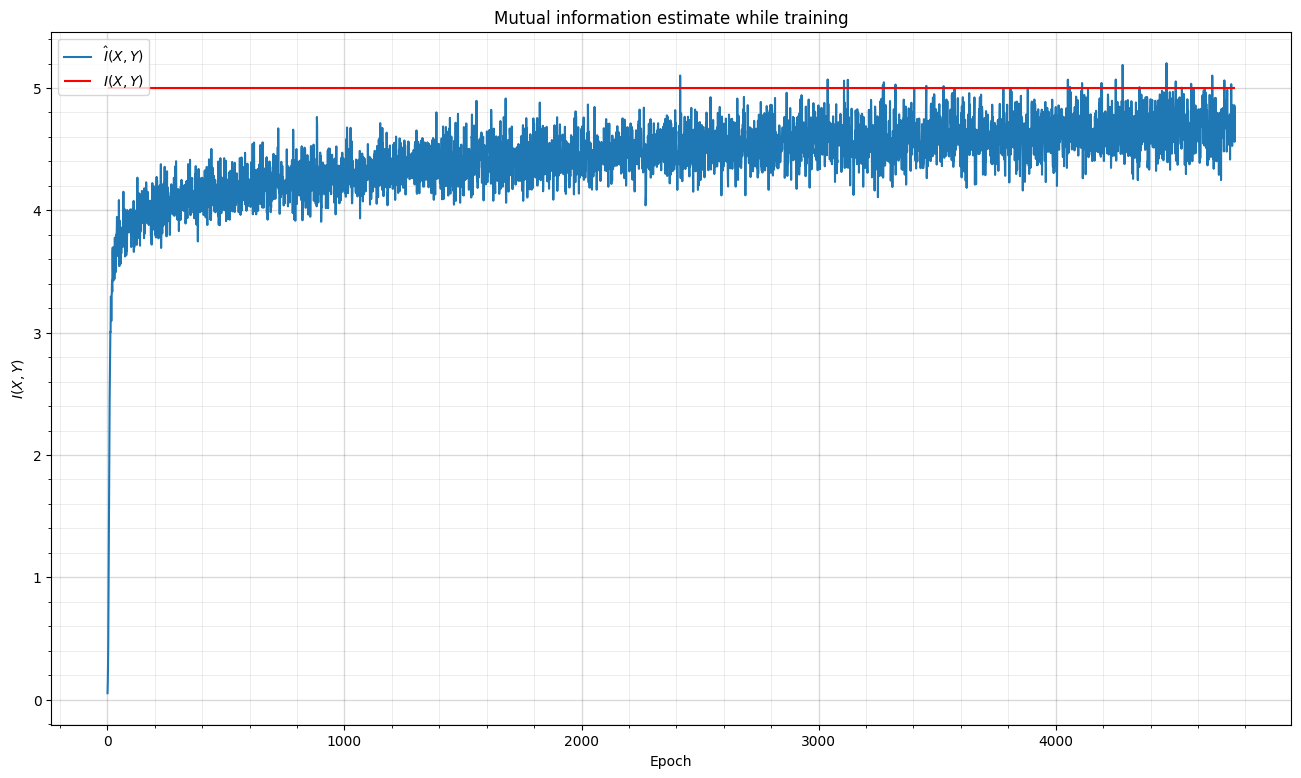

Current estimate: 4.84
Current exp(T) moving average: 0.00
Epoch №4756


12it [00:00, 40.10it/s]


In [ ]:
from IPython.display import clear_output
n_epochs = 20000

estimated_MI = []
for epoch in range(1, n_epochs + 1):    
    # Training.
    print(f"Epoch №{epoch}")        
    for index, batch in tqdm(enumerate(dataloader)):
        x, y, z = batch
        batch_size = x.shape[0]
        
        model.zero_grad()
        T_joined   = model(x.to(device), y.to(device))
        T_marginal = model(x.to(device), y.to(device), permute=True)
        #T_marginal = model(z.to(device), y.to(device))
        _loss = loss(T_joined, T_marginal)
        _loss.backward()
        opt.step()
        
    estimated_MI.append(model.get_mutual_information(dataloader, loss, device))
    
    clear_output(wait=True)
    
    plot_estimated_MI_trainig(np.arange(1, epoch+1), estimated_MI, mutual_information)
        
    print(f"Current estimate: {estimated_MI[-1]:.2f}")
    print(f"Current exp(T) moving average: {loss.moving_average:.2f}")